In [1]:
import jax
import jax.numpy as np
from jax import lax
from jax import scipy
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Sine(dist.Distribution):
    def __init__(self, alpha=np.array(1.), sigma1=np.array(3e-3), sigma2=np.array(1.0), validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(alpha), np.shape(sigma1), np.shape(sigma2))
        self.alpha = np.broadcast_to(alpha, batch_shape)
        self.sigma1 = np.broadcast_to(sigma1, batch_shape)
        self.sigma2 = np.broadcast_to(sigma2, batch_shape)
        super(Sine, self).__init__(batch_shape=batch_shape, validate_args=validate_args)

    def log_prob(self, value):
        return - (value[..., 1] + np.sin(self.alpha * value[..., 0])) ** 2 / (2 * self.sigma1) -\
                (value[..., 0] ** 2 + value[..., 1] ** 2) / (2 * self.sigma2)

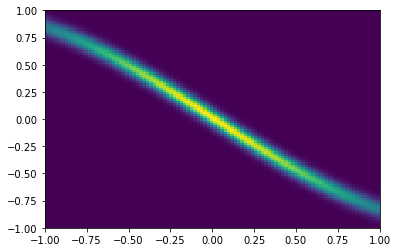

In [3]:
xs = np.linspace(-1, 1, num=100)
ys = np.linspace(-1, 1, num=100)
zs = np.stack(np.meshgrid(xs, ys), axis=-1)
lps = np.exp(Sine().log_prob(zs))
plt.pcolormesh(xs, ys, lps)
plt.show()

In [4]:
class DoubleBanana(dist.Distribution):
    def __init__(self, y=np.log(30.), sigma1=np.array(1.0), sigma2=np.array(9e-2), validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(y), np.shape(sigma1), np.shape(sigma2))
        self.y = np.broadcast_to(y, batch_shape)
        self.sigma1 = np.broadcast_to(sigma1, batch_shape)
        self.sigma2 = np.broadcast_to(sigma2, batch_shape)
        super(DoubleBanana, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        fx = np.log((1 - value[..., 0]) ** 2.0 + 100 * (value[..., 1] - value[..., 0] ** 2.0) ** 2.0)
        return - np.sqrt(value[..., 0] ** 2.0 + value[..., 1] ** 2.0) ** 2.0 / (2.0 * self.sigma1) -\
                 (self.y - fx) ** 2.0 / (2.0 * self.sigma2)

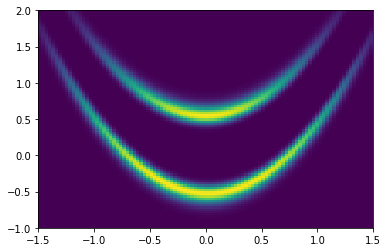

In [5]:
xs = np.linspace(-1.5, 1.5, num=100)
ys = np.linspace(-1, 2, num=100)
zs = np.stack(np.meshgrid(xs, ys), axis=-1)
lps = np.exp(DoubleBanana().log_prob(zs))
plt.pcolormesh(xs, ys, lps)
plt.show()

In [6]:
class Star(dist.Distribution):
    def __init__(self, mu0=np.array([0., 1.5]), cov0=np.diag(np.array([1e-2, 0.5])), n_comp=5, validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(mu0)[:-1], np.shape(cov0)[:-2])
        mu0 = np.broadcast_to(mu0, batch_shape + np.shape(mu0)[-1:])
        cov0 = np.broadcast_to(cov0, batch_shape + np.shape(cov0)[-2:])
        self.n_comp = n_comp
        mus = [mu0]
        covs = [cov0]
        theta = 2 * np.pi / n_comp
        rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
        for i in range(n_comp - 1):
            mui = rot @ mus[-1]
            covi = rot @ covs[-1] @ rot.transpose()
            mus.append(mui)
            covs.append(covi)
        self.mus = np.stack(mus)
        self.covs = np.stack(covs)
        super(Star, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        lps = []
        for i in range(self.n_comp):
            lps.append(dist.MultivariateNormal(self.mus[i], self.covs[i]).log_prob(value))
        return scipy.special.logsumexp(np.stack(lps, axis=0), axis=0) / self.n_comp

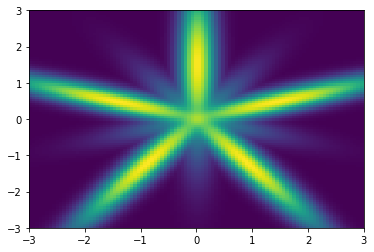

In [7]:
xs = np.linspace(-3, 3, num=100)
ys = np.linspace(-3, 3, num=100)
zs = np.stack(np.meshgrid(xs, ys), axis=-1)
lps = np.exp(Star().log_prob(zs))
plt.pcolormesh(xs, ys, lps)
plt.show()